In [1]:
#!pip install backtrader

In [2]:
from datetime import datetime
import backtrader as bt
import matplotlib
import pandas as pd
import math

matplotlib.__version__

'3.2.2'

Buy Signal:

* Price > Tenkan
* Price > Kijun

* Tenkan > Kijun

* Price > SenkoA
* Price > SenkoB

* Tenkan > SenkoA
* Tenkan > SenkoB

* Kijun > SenkoA
* Kijun > SenkoB

* SenkoA > SenkoB

* Chikou > price 26 days ago
* Chikou projected 10 days out should not be lower than price 10 days ago

* teankan pointing up
* kijun pointing up
* chikou pointing up
* future senkouA pointing up
* future senkouB pointing up

Sell Signal:

* Price < Tenkan
* Price < Kijun

* Tenkan < Kijun

* Price < SenkoA
* Price < SenkoB

* Tenkan < SenkoA
* Tenkan < SenkoB

* Kijun < SenkoA
* Kijun < SenkoB

* SenkoA < SenkoB

* Chikou < price 26 days ago
* Chikou projected 10 days out should not be higher than price 10 days ago

* teankan pointing down
* kijun pointing down
* chikou pointing down
* future senkouA pointing down
* future senkouB pointing down

In [3]:
cerebro = bt.Cerebro()

In [4]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    
    params = (
                ('tenkan', 9),
                ('kijun', 26),
                ('senkou', 52),
                ('senkou_lead', 26),  # forward push
                ('chikou', 26),  # backwards push
            )

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.f_senkou_b_t_minus_one = math.nan
        
        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a Ichimoku indicator
        self.ichimoku = bt.indicators.Ichimoku(self.datas[0],
                                           tenkan=self.params.tenkan,
                                           kijun=self.params.kijun,
                                           senkou=self.params.senkou,
                                           senkou_lead=self.params.senkou_lead,
                                           chikou=self.params.chikou)
    

    def log(self, txt, dt=None):
        '''Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Comm {order.executed.comm}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm 
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Comm {order.executed.comm}')
    
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset order status to prepare for next order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION PROFIT, GROSS: {trade.pnl}, NET: {trade.pnlcomm}')

#     def next(self):
#         # Simply log the closing price of the series from the reference
#         # self.log(f'Close, {self.dataclose[0]}')

#         # Check if an order is pending ... if yes, we cannot send a 2nd one
#         if self.order:
#             return

#         # Check if we are in the market
#         if not self.position:

#             # Not yet ... we MIGHT BUY if ...
#             if self.ichimoku.tenkan_sen[0] > self.ichimoku.kijun_sen[0]:

#                 # BUY, BUY, BUY!!! (with all possible default parameters)
#                 self.log(f'BUY CREATE, {self.dataclose[0]}')

#                 # Keep track of the created order to avoid a 2nd order
#                 self.order = self.buy()

#         else:

#             if self.ichimoku.tenkan_sen[0] < self.ichimoku.kijun_sen[0]:
#                 # SELL, SELL, SELL!!! (with all possible default parameters)
#                 self.log(f'SELL CREATE, {self.dataclose[0]}')

#                 # Keep track of the created order to avoid a 2nd order
#                 self.order = self.sell()

    @staticmethod
    def _senkou_span_a(tenkan_sen,kijun_sen):        
        # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
        return ((pd.Series(tenkan_sen) + pd.Series(kijun_sen)) / 2)
    
    @staticmethod
    def _senkou_span_b(price):        
        # Senkou Span B (Leading Span B): (Highest High + Lowest Low)/2))
        return ((pd.Series(price).max() + pd.Series(price).min()) / 2)
    
    def next(self):
        self.log(f'========================================')
        self.log(f'Today Close, {self.dataclose[0]}')
        self.log(f'Today Tenkan, {self.ichimoku.tenkan_sen[0]}')
        self.log(f't-1 Tenkan, {self.ichimoku.tenkan_sen[-1]}')
        self.log(f'Today Kijun, {self.ichimoku.kijun_sen[0]}')
        self.log(f't-1 Kijun, {self.ichimoku.kijun_sen[-1]}')
        self.log(f'26 day ago Chikou, {self.ichimoku.chikou_span[-26]}')
        self.log(f'27 day ago Chikou, {self.ichimoku.chikou_span[-27]}')
        self.log(f'26 day ago Close, {self.dataclose[-26]}')
        self.log(f'16 day ago Close, {self.dataclose[-16]}')
        self.log(f'Today SenkouA, {self.ichimoku.senkou_span_a[0]}')
        self.log(f'Today SenkouB, {self.ichimoku.senkou_span_b[0]}')
        
            
        f_senkou_a = self._senkou_span_a(tenkan_sen=self.ichimoku.l.tenkan_sen.get(size=26),
                                       kijun_sen=self.ichimoku.l.kijun_sen.get(size=26))
        
        f_senkou_b = self._senkou_span_b([self.datas[0].close[i] for i in range(0, -52, -1)])       
        
        self.log(f'Future SenkouA {f_senkou_a[25]}')
        self.log(f'Future SenkouA t-1 {f_senkou_a[24]}')
        self.log(f'Future SenkouB {f_senkou_b}')
        
        self.log(f'Future SenkouB t-1 {self.f_senkou_b_t_minus_one}')
        self.f_senkou_b_t_minus_one = f_senkou_b
        #self.log(f'Last 52 days price {[self.datas[0].close[i] for i in range(0, -52, -1)]}')

In [5]:
# Add a strategy
cerebro.addstrategy(TestStrategy)

0

In [6]:
data = bt.feeds.YahooFinanceData(dataname='^NSEI', fromdate=datetime(2020, 1, 1),
                                  todate=datetime(2020, 12, 31))
cerebro.adddata(data)

In [7]:
cerebro.broker.setcash(10_00_000.0)

In [8]:
# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=3) #buy/sell 3 futures

In [9]:
# Set the commission - Rs 20 per transcation
cerebro.broker.setcommission(commission=20, margin=1_70_000)

In [10]:
starting = cerebro.broker.getvalue()
print(f'Starting Portfolio Value: {starting}')

Starting Portfolio Value: 1000000.0


In [11]:
%%time
cerebro.run()

2020-04-27, ========================================
2020-04-27, Today Close, 9282.3
2020-04-27, Today Tenkan, 9106.375
2020-04-27, t-1 Tenkan, 9106.375
2020-04-27, Today Kijun, 8457.45
2020-04-27, t-1 Kijun, 8556.650000000001
2020-04-27, 26 day ago Chikou, 9282.3
2020-04-27, 27 day ago Chikou, 9154.4
2020-04-27, 26 day ago Close, 9197.4
2020-04-27, 16 day ago Close, 8281.1
2020-04-27, Today SenkouA, 10186.625
2020-04-27, Today SenkouB, 10492.825
2020-04-27, Future SenkouA 8781.9125
2020-04-27, Future SenkouA t-1 8831.5125
2020-04-27, Future SenkouB 9905.725
2020-04-27, Future SenkouB t-1 nan
2020-04-28, ========================================
2020-04-28, Today Close, 9380.9
2020-04-28, Today Tenkan, 9113.15
2020-04-28, t-1 Tenkan, 9106.375
2020-04-28, Today Kijun, 8457.75
2020-04-28, t-1 Kijun, 8457.45
2020-04-28, 26 day ago Chikou, 9380.9
2020-04-28, 27 day ago Chikou, 9282.3
2020-04-28, 26 day ago Close, 8967.05
2020-04-28, 16 day ago Close, 8597.75
2020-04-28, Today SenkouA, 10186

2020-06-10, Future SenkouA 9710.1625
2020-06-10, Future SenkouA t-1 9700.0625
2020-06-10, Future SenkouB 8888.85
2020-06-10, Future SenkouB t-1 8888.85
2020-06-11, ========================================
2020-06-11, Today Close, 9902.0
2020-06-11, Today Tenkan, 10017.725
2020-06-11, t-1 Tenkan, 9852.7
2020-06-11, Today Kijun, 9567.625
2020-06-11, t-1 Kijun, 9567.625
2020-06-11, 26 day ago Chikou, 9902.0
2020-06-11, 27 day ago Chikou, 10116.15
2020-06-11, 26 day ago Close, 9205.6
2020-06-11, 16 day ago Close, 8879.1
2020-06-11, Today SenkouA, 9058.8625
2020-06-11, Today SenkouB, 9878.900000000001
2020-06-11, Future SenkouA 9792.675
2020-06-11, Future SenkouA t-1 9710.1625
2020-06-11, Future SenkouB 8984.25
2020-06-11, Future SenkouB t-1 8888.85
2020-06-12, ========================================
2020-06-12, Today Close, 9972.9
2020-06-12, Today Tenkan, 9936.425
2020-06-12, t-1 Tenkan, 10017.725
2020-06-12, Today Kijun, 9567.625
2020-06-12, t-1 Kijun, 9567.625
2020-06-12, 26 day ago Ch

2020-07-29, 27 day ago Chikou, 11300.55
2020-07-29, 26 day ago Close, 10471.0
2020-07-29, 16 day ago Close, 10799.65
2020-07-29, Today SenkouA, 9830.125
2020-07-29, Today SenkouB, 9422.825
2020-07-29, Future SenkouA 10906.7375
2020-07-29, Future SenkouA t-1 10856.3
2020-07-29, Future SenkouB 10061.9
2020-07-29, Future SenkouB t-1 10061.9
2020-07-30, ========================================
2020-07-30, Today Close, 11102.15
2020-07-30, Today Tenkan, 11147.2
2020-07-30, t-1 Tenkan, 11045.525
2020-07-30, Today Kijun, 10767.95
2020-07-30, t-1 Kijun, 10767.95
2020-07-30, 26 day ago Chikou, 11102.15
2020-07-30, 27 day ago Chikou, 11202.85
2020-07-30, 26 day ago Close, 10305.3
2020-07-30, 16 day ago Close, 10705.75
2020-07-30, Today SenkouA, 9876.4875
2020-07-30, Today SenkouB, 9603.525
2020-07-30, Future SenkouA 10957.575
2020-07-30, Future SenkouA t-1 10906.7375
2020-07-30, Future SenkouB 10089.825
2020-07-30, Future SenkouB t-1 10061.9
2020-07-31, ========================================
2

2020-09-09, Future SenkouA 11459.425
2020-09-09, Future SenkouA t-1 11437.075
2020-09-09, Future SenkouB 10974.85
2020-09-09, Future SenkouB t-1 10974.85
2020-09-10, ========================================
2020-09-10, Today Close, 11449.25
2020-09-10, Today Tenkan, 11489.7
2020-09-10, t-1 Tenkan, 11489.7
2020-09-10, Today Kijun, 11452.85
2020-09-10, t-1 Kijun, 11429.15
2020-09-10, 26 day ago Chikou, 11449.25
2020-09-10, 27 day ago Chikou, 11278.0
2020-09-10, 26 day ago Close, 11101.65
2020-09-10, 16 day ago Close, 11408.4
2020-09-10, Today SenkouA, 10966.1625
2020-09-10, Today SenkouB, 10169.025
2020-09-10, Future SenkouA 11471.275000000001
2020-09-10, Future SenkouA t-1 11459.425
2020-09-10, Future SenkouB 11038.825
2020-09-10, Future SenkouB t-1 10974.85
2020-09-11, ========================================
2020-09-11, Today Close, 11464.45
2020-09-11, Today Tenkan, 11385.05
2020-09-11, t-1 Tenkan, 11489.7
2020-09-11, Today Kijun, 11452.85
2020-09-11, t-1 Kijun, 11452.85
2020-09-11, 

2020-10-27, Future SenkouA 11625.6
2020-10-27, Future SenkouA t-1 11625.6
2020-10-27, Future SenkouB 11388.3
2020-10-27, Future SenkouB t-1 11388.3
2020-10-28, ========================================
2020-10-28, Today Close, 11729.6
2020-10-28, Today Tenkan, 11843.25
2020-10-28, t-1 Tenkan, 11843.375
2020-10-28, Today Kijun, 11407.825
2020-10-28, t-1 Kijun, 11407.825
2020-10-28, 26 day ago Chikou, 11729.6
2020-10-28, 27 day ago Chikou, 11889.4
2020-10-28, 26 day ago Close, 11250.55
2020-10-28, 16 day ago Close, 11662.4
2020-10-28, Today SenkouA, 11435.5
2020-10-28, Today SenkouB, 11178.575
2020-10-28, Future SenkouA 11625.5375
2020-10-28, Future SenkouA t-1 11625.6
2020-10-28, Future SenkouB 11388.3
2020-10-28, Future SenkouB t-1 11388.3
2020-10-29, ========================================
2020-10-29, Today Close, 11670.8
2020-10-29, Today Tenkan, 11812.55
2020-10-29, t-1 Tenkan, 11843.25
2020-10-29, Today Kijun, 11407.825
2020-10-29, t-1 Kijun, 11407.825
2020-10-29, 26 day ago Chikou

2020-12-14, Future SenkouA 13051.537499999999
2020-12-14, Future SenkouA t-1 12969.475
2020-12-14, Future SenkouB 12390.275
2020-12-14, Future SenkouB t-1 12375.75
2020-12-15, ========================================
2020-12-15, Today Close, 13567.85
2020-12-15, Today Tenkan, 13352.7
2020-12-15, t-1 Tenkan, 13290.525
2020-12-15, Today Kijun, 12864.675
2020-12-15, t-1 Kijun, 12812.55
2020-12-15, 26 day ago Chikou, 13567.85
2020-12-15, 27 day ago Chikou, 13558.15
2020-12-15, 26 day ago Close, 12120.3
2020-12-15, 16 day ago Close, 12859.05
2020-12-15, Today SenkouA, 11745.550000000001
2020-12-15, Today SenkouB, 11460.650000000001
2020-12-15, Future SenkouA 13108.6875
2020-12-15, Future SenkouA t-1 13051.537499999999
2020-12-15, Future SenkouB 12407.7
2020-12-15, Future SenkouB t-1 12390.275
2020-12-16, ========================================
2020-12-16, Today Close, 13682.7
2020-12-16, Today Tenkan, 13422.6
2020-12-16, t-1 Tenkan, 13352.7
2020-12-16, Today Kijun, 13029.85
2020-12-16, t-1

In [12]:
ending = cerebro.broker.getvalue()
print(f'Final Portfolio Value: {ending}')

Final Portfolio Value: 1000000.0


In [13]:
print(f'Returns: {round(((ending - starting)/starting)*100, 2)}%')

Returns: 0.0%


<IPython.core.display.Javascript object>


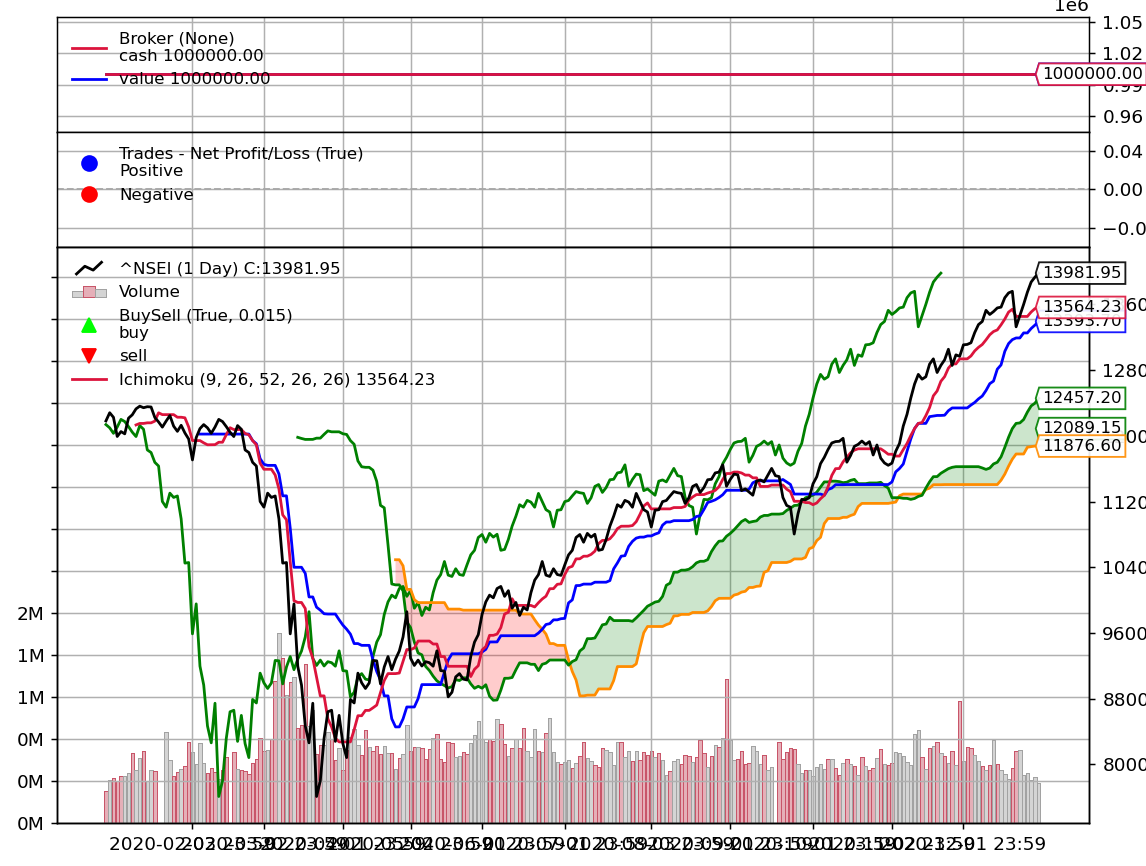

[[<Figure size 640x480 with 4 Axes>]]

In [14]:
cerebro.plot()